In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
**Author**: [Sean Robertson](https://github.com/spro)

This is the third and final tutorial on doing "NLP From Scratch", where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks. We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you in the
three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215)_, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473)_, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](https://arxiv.org/abs/1406.1078)_
-  [Sequence to Sequence Learning with Neural
   Networks](https://arxiv.org/abs/1409.3215)_
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](https://arxiv.org/abs/1409.0473)_
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)_

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

**Requirements**


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading data files

The data for this project is a set of many thousands of English to
French translation pairs.

[This question on Open Data Stack
Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)_
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repository, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.



In [37]:
!curl -O -J -L 'https://download.pytorch.org/tutorial/data.zip'
!unzip 'data.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  9802k      0 --:--:-- --:--:-- --:--:-- 9841k
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['je me vets', 'i am getting dressed']


## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence ``Je ne suis pas le chat noir`` → ``I am not the
black cat``. Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. ``chat noir`` and ``black cat``. Because of the ``ne/pas``
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




**Simple Decoder**

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




#### Task 1: Attention Decoder (20pts)

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:


Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in neural
machine translation tasks. It was introduced by Bahdanau et al. in their
paper titled [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)_.
This attention mechanism employs a learned alignment model to compute attention
scores between the encoder and decoder hidden states. It utilizes a feed-forward
neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as Luong attention,
which computes attention scores by taking the dot product between the decoder hidden
state and the encoder hidden states. It does not involve the non-linear transformation
used in Bahdanau attention.

In the following code block, implement the Bahdanau attention method for our NMT model.



In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        ### Your code here
        # Initialize decoder input and hidden states
        batchSize = encoder_outputs.size(0)
        dec_input = torch.empty(batchSize, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden # pass encoder value

        # Initialize empty lists
        decoder_outputs = []
        attentions = []

        # loop
        for i in range(MAX_LENGTH):
            dec_output, decoder_hidden, attn_wts = self.forward_step(dec_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(dec_output) # append to the list
            attentions.append(attn_wts)

            # If it is present
            if target_tensor is not None:
                # Force the model to learn: Use the target as the next input (Teacher forcing)
                dec_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Use the default predictions for the input
                _, top_index = dec_output.topk(1)
                dec_input = top_index.squeeze(-1).detach()

        # Concatenate decoder outputs and apply log softmax
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        ### Your code here
        # Get input from the embedding layer
        embedded_input = self.dropout(self.embedding(input))

        # Apply the attention mechanism
        query_vector = hidden.permute(1, 0, 2)
        context_vector, attn_wts = self.attention(query_vector, encoder_outputs)
        input_gru = torch.cat((embedded_input, context_vector), dim=2)

        # Pass the input through the GRU and output layer
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_wts

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in [Effective Approaches to Attention-based Neural Machine
  Translation](https://arxiv.org/abs/1508.04025)_.</p></div>

## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, lang1, lang2):
    input_lang, output_lang, pairs = prepareData(lang1, lang2, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [17]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Task 2: Training and Evaluating (10pts)

Evaluate and compare both architectures (simple and attn).

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [34]:
# Initialize parameters
hidden_size = 128
batch_size = 32

# Load the data and create data loaders
input_lang, output_lang, train_dataloader = get_dataloader(batch_size, 'eng', 'fra')

# Train the simple model (Encoder-Decoder)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

### Train the simple decoder model

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 21s (- 5m 20s) (5 6%) 1.6790
0m 41s (- 4m 49s) (10 12%) 0.9087
1m 1s (- 4m 27s) (15 18%) 0.5954
1m 21s (- 4m 4s) (20 25%) 0.4079
1m 41s (- 3m 43s) (25 31%) 0.2878
2m 2s (- 3m 23s) (30 37%) 0.2085
2m 21s (- 3m 2s) (35 43%) 0.1550
2m 41s (- 2m 41s) (40 50%) 0.1203
3m 1s (- 2m 20s) (45 56%) 0.0954
3m 21s (- 2m 0s) (50 62%) 0.0780
3m 41s (- 1m 40s) (55 68%) 0.0662
4m 0s (- 1m 20s) (60 75%) 0.0568
4m 20s (- 1m 0s) (65 81%) 0.0517
4m 40s (- 0m 40s) (70 87%) 0.0461
4m 59s (- 0m 19s) (75 93%) 0.0429
5m 20s (- 0m 0s) (80 100%) 0.0391


<Figure size 640x480 with 0 Axes>

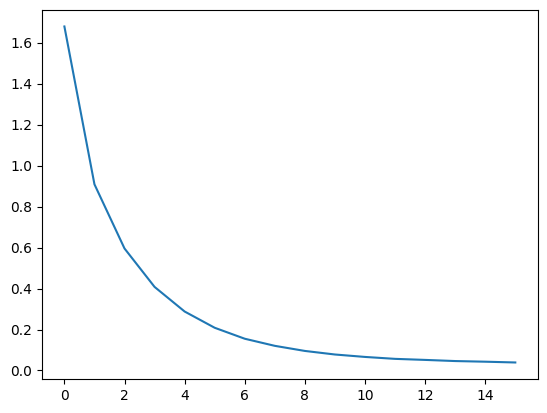

In [21]:
%matplotlib inline

decoder_simple = DecoderRNN(hidden_size, output_lang.n_words).to(device)
train(train_dataloader, encoder, decoder_simple, 80, print_every=5, plot_every=5)

### Train the attention-based model (Encoder-AttnDecoder)


0m 36s (- 9m 14s) (5 6%) 1.3580
1m 13s (- 8m 35s) (10 12%) 0.5332
1m 50s (- 7m 57s) (15 18%) 0.2710
2m 27s (- 7m 21s) (20 25%) 0.1549
3m 3s (- 6m 44s) (25 31%) 0.0997
3m 41s (- 6m 9s) (30 37%) 0.0721
4m 18s (- 5m 32s) (35 43%) 0.0577
4m 55s (- 4m 55s) (40 50%) 0.0492
5m 31s (- 4m 18s) (45 56%) 0.0432
6m 10s (- 3m 42s) (50 62%) 0.0398
6m 51s (- 3m 6s) (55 68%) 0.0368
7m 29s (- 2m 29s) (60 75%) 0.0349
8m 8s (- 1m 52s) (65 81%) 0.0326
8m 47s (- 1m 15s) (70 87%) 0.0330
9m 26s (- 0m 37s) (75 93%) 0.0310
10m 6s (- 0m 0s) (80 100%) 0.0300


<Figure size 640x480 with 0 Axes>

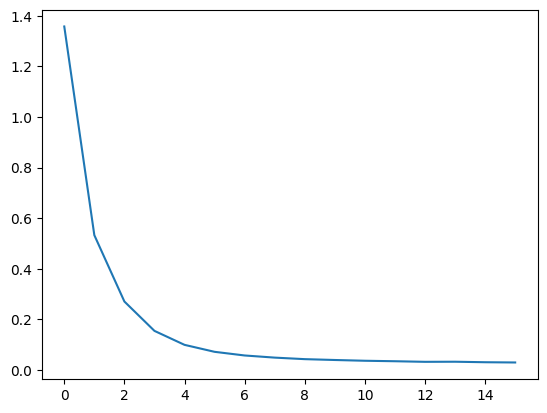

In [22]:
%matplotlib inline
decoder_attn = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
train(train_dataloader, encoder, decoder_attn, 80, print_every=5, plot_every=5)

Set dropout layers to ``eval`` mode



In [24]:
print("Evaluation Results for simple decoder")
encoder.eval()
decoder_simple.eval()
evaluateRandomly(encoder, decoder_simple)

Evaluation Results for simple decoder
> je me prepare au pire
= i m getting ready for the worst
< i m wondering if i love her <EOS>

> je suis depourvue de talent
= i m untalented
< i m back into this way home <EOS>

> il enseigne depuis ans
= he s been teaching for years
< he s been passing off my job <EOS>

> vous etes trop polie
= you re too polite
< you re too late to live <EOS>

> je suis en train de me peser
= i am weighing myself
< i am in favor of the proposition <EOS>

> ils sont tous en vacances
= they re all on vacation
< they re all in the same team <EOS>

> je suis cultivee
= i m cultured
< i m willing to go now <EOS>

> il a peur de faire des erreurs
= he s afraid of making mistakes
< he is watching tv now <EOS>

> c est toi qui t es emballee
= you re the one that went crazy
< you re the one who planted that tree <EOS>

> nous sommes completement cool avec ca
= we re totally cool with that
< we re prepared to hear that next sunday <EOS>



**It can be seen that the simple decoder is not performing too well for most cases.**

In [25]:
print("Evalutation Results for attention decoder")
encoder.eval()
decoder_simple.eval()
evaluateRandomly(encoder, decoder_attn)

Evalutation Results for attention decoder
> il depend completement de ses parents
= he is totally dependent on his parents
< he is totally dependent on his parents in his parents

> vous n interrompez rien
= you re not interrupting anything
< you re not interrupting anything anything <EOS>

> nous sommes tres en retard
= we re really late
< we re really late <EOS>

> tu es tellement gentil !
= you re so sweet
< you re so sweet <EOS>

> elle est belle comme blanche neige
= she is as beautiful as snow white
< she is as beautiful as snow white <EOS>

> j y compte
= i m counting on it
< i m counting on his own <EOS>

> tu es dans le mauvais train
= you are on the wrong train
< you are on the wrong train <EOS>

> tu es mignonne dans ton genre
= you re kind of cute
< you re kind of cute when <EOS>

> je suis plus elegante que vous
= i m smarter than you
< i m smarter than you <EOS>

> je suis mecontente
= i m unhappy
< i m unhappy confused <EOS>



**It can be seen that the attention decoder performs much better for most cases as compared to the simple decoder.**

### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix. For a better viewing experience we will do the
extra work of adding axes and labels:




input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


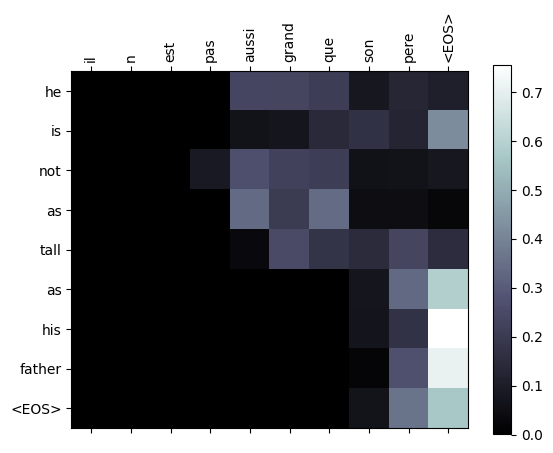

input = je suis trop fatigue pour conduire
output = i m too tired to drive a job <EOS>


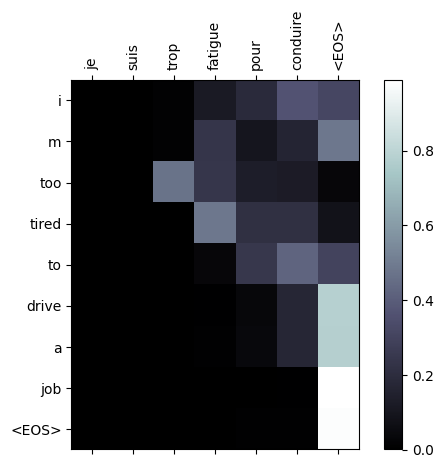

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


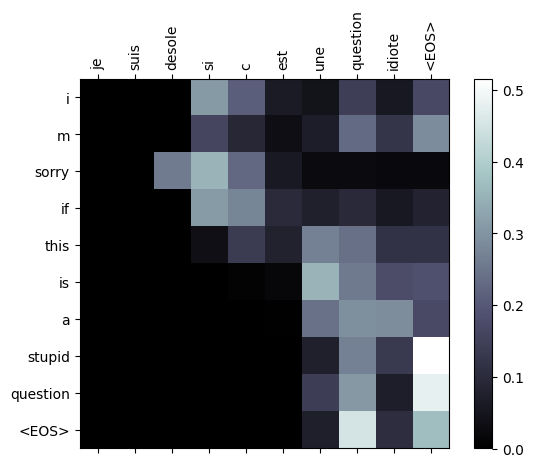

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


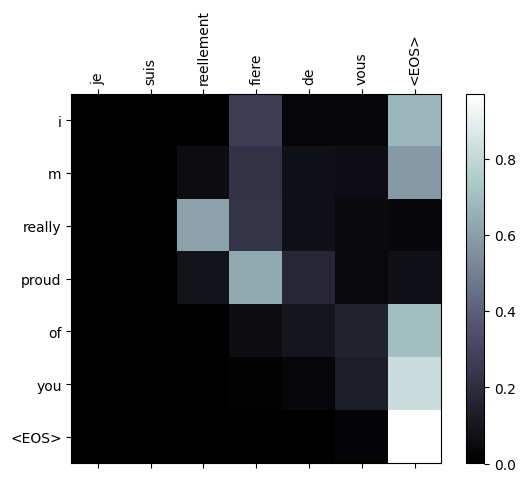

In [26]:
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    # axes.xaxis.set_ticks(values_list)
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder_attn, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

## Exercises

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pretrained word embeddings such as ``word2vec`` or
   ``GloVe``
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




## Creating a English to Nepali Translator

In [40]:
!curl -O -J -L 'http://www.manythings.org/anki/npi-eng.zip'
!unzip 'npi-eng.zip' -d 'data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64697  100 64697    0     0   273k      0 --:--:-- --:--:-- --:--:--  274k
Archive:  npi-eng.zip
  inflating: data/npi.txt            
  inflating: data/_about.txt         


In [29]:
# Update functions to suit the Nepali dataset
def normalizeNepString(s):
    s = re.sub(r"([.!।?])", r" \1", s)
    return s.strip()

def readNepLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/npi.txt', encoding='utf-8').read().strip().split('\n')

    pairs = []
    for l in lines:
      eng = normalizeString(l.split('\t')[0])
      nep = normalizeNepString(l.split('\t')[1])
      pairs.append([eng, nep])

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareNepData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readNepLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(f"Input language name: {input_lang.name} and num of words: {input_lang.n_words}")
    print(f"Output language name: {output_lang.name} and num of words: {output_lang.n_words}")
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareNepData('eng', 'nep', True)
print(random.choice(pairs))

Reading lines...
Read 1574 sentence pairs
Trimmed to 191 sentence pairs
Counting words...
Counted words:
Input language name: nep and num of words: 306
Output language name: eng and num of words: 264
['म पढ्दै छु ।', 'i am studying']


In [30]:
def get_Nepdataloader(batch_size, lang1, lang2):
    input_lang, output_lang, pairs = prepareNepData(lang1, lang2, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

**Training the RNN with Eng-Nepali dataset**

Reading lines...
Read 1574 sentence pairs
Trimmed to 191 sentence pairs
Counting words...
Counted words:
Input language name: nep and num of words: 306
Output language name: eng and num of words: 264
0m 1s (- 0m 19s) (5 6%) 3.0003
0m 1s (- 0m 13s) (10 12%) 1.7297
0m 2s (- 0m 10s) (15 18%) 1.3970
0m 3s (- 0m 9s) (20 25%) 1.1479
0m 3s (- 0m 7s) (25 31%) 0.9347
0m 4s (- 0m 6s) (30 37%) 0.7565
0m 4s (- 0m 6s) (35 43%) 0.6117
0m 5s (- 0m 5s) (40 50%) 0.4997
0m 5s (- 0m 4s) (45 56%) 0.4127
0m 6s (- 0m 3s) (50 62%) 0.3441
0m 7s (- 0m 3s) (55 68%) 0.2897
0m 7s (- 0m 2s) (60 75%) 0.2435
0m 8s (- 0m 1s) (65 81%) 0.2021
0m 9s (- 0m 1s) (70 87%) 0.1677
0m 9s (- 0m 0s) (75 93%) 0.1389
0m 10s (- 0m 0s) (80 100%) 0.1159


<Figure size 640x480 with 0 Axes>

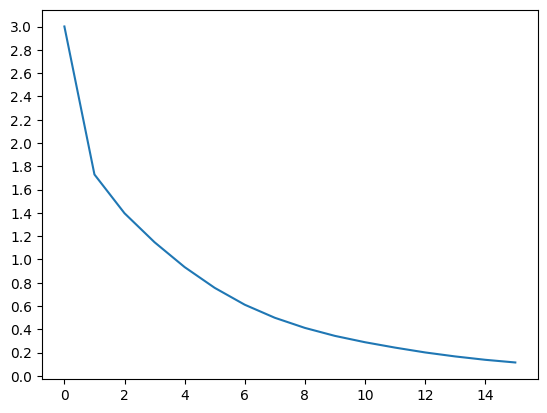

In [31]:
# Train the
%matplotlib inline

hidden_size = 128
batch_size = 32

input_lang_2, output_lang_2, train_Nepdataloader = get_Nepdataloader(batch_size, 'eng', 'nep')

encoderNep = EncoderRNN(input_lang_2.n_words, hidden_size).to(device)
decoderNep = AttnDecoderRNN(hidden_size, output_lang_2.n_words).to(device)

train(train_Nepdataloader, encoderNep, decoderNep, 80, print_every=5, plot_every=5)

**Evaluating the dataset**

In [32]:
encoderNep.eval()
decoderNep.eval()
evaluateRandomly(encoderNep, decoderNep)

> उनी आठ वर्षकी हुन्  ।
= she is eight
< she is eight <EOS>

> म साँच्चै टमको भ्रमणको लागि पर्खिरहेको छु ।
= i m really looking forward to tom s visit
< i m really looking forward to tom s visit in

> म जापानीज हुँ ।
= i am japanese
< i am japanese <EOS>

> म मोटो छु ।
= i m chubby
< i m chubby <EOS>

> ऊ शक्तिशाली छ ।
= he is powerful
< he is powerful <EOS>

> म पक्का छु कि टम सक्षम छ ।
= i m pretty sure tom s competent
< i m pretty sure tom s competent <EOS>

> म चाइनिज हुँ ।
= i am chinese
< i m not courageous <EOS>

> म कुक हुँ ।
= i am a cook
< i m a criminal <EOS>

> ऊ अविवाहित छ ।
= he is unmarried
< he is unmarried <EOS>

> म टमको दाईसँग साथी छु ।
= i m friends with tom s brother
< i m friends with tom s brother <EOS>



**The attention decoder trained on a new dataset with limited data still performs really well.**

input = हामी पुरुष हौं ।
output = we are classmates <EOS>


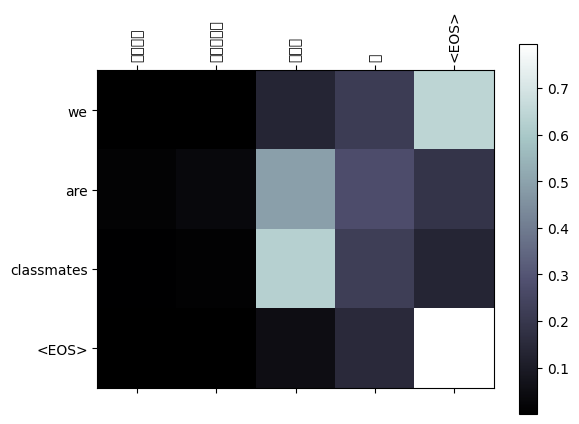

In [33]:
%matplotlib inline

def evaluateAndShowNepAttention(input_sentence):
    output_words, attentions = evaluate(encoderNep, decoderNep, input_sentence, input_lang_2, output_lang_2)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

evaluateAndShowNepAttention('हामी पुरुष हौं ।')